## Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import folium
import warnings
import builtins

from folium.plugins import HeatMap
warnings.filterwarnings("ignore", category=UserWarning, module='transbigdata.plotmap')

## The Dataset

In [6]:
df = pd.read_csv("bikedata-sample.csv")

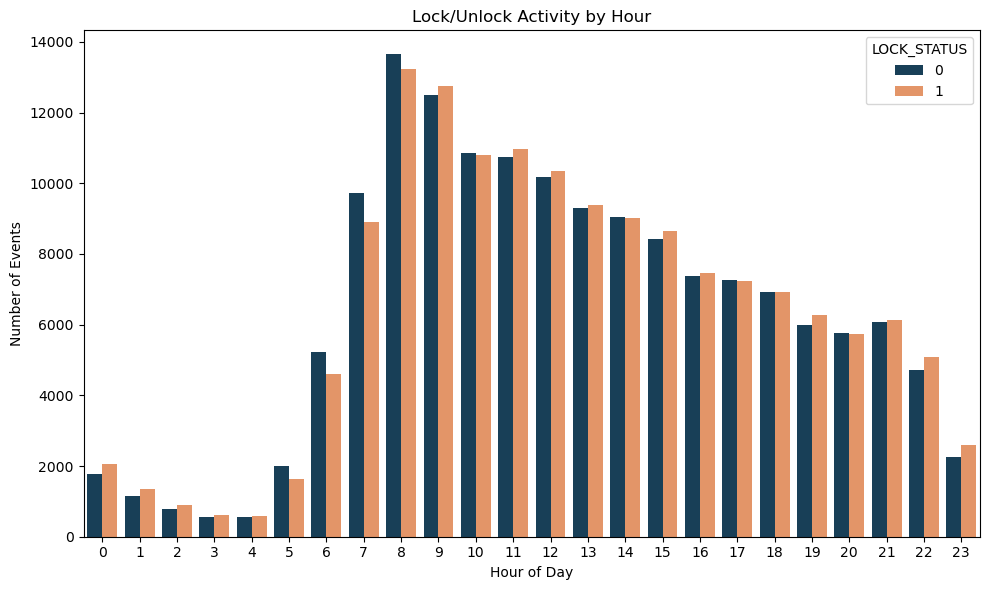

In [8]:
df_reset = df.reset_index()

df_reset['DATA_TIME'] = pd.to_datetime(df_reset['DATA_TIME'], format='mixed', errors='coerce')
df_reset = df_reset.dropna(subset=['DATA_TIME'])
df_reset['Hour'] = df_reset['DATA_TIME'].dt.hour

plt.figure(figsize=(10, 6))

custom_palette = {0: '#0D4262', 1: '#F79054'}  

sns.countplot(data=df_reset, x='Hour', hue='LOCK_STATUS', palette=custom_palette)

plt.title("Lock/Unlock Activity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()

> We see a huge increase starting from 7 AM, experiencing the highest peak at 8 AM and slightly dropping then at 9 AM in the lock, meaning that a lot of bikes are taken at that time slot, and also seeing the lock = 0 likewise increase trend at the same time slot can mean that people take the bikes and return them in a short period. From 10 AM to 3 PM, locks and unlocks have a balanced dropping relationship, and from 4 PM, locks start to rise, meaning that "it's time for people to go home," and some of them take bikes; this trend goes till 10-11 PM. Not surprisingly, we see very low numbers for both lock and unlock values starting from 12 AM to 5 AM.

### Bike Movement Heatmap (Using Folium)

In [12]:
taken = df[df['LOCK_STATUS'] == 1]

m = folium.Map(location=[taken['LATITUDE'].mean(), taken['LONGITUDE'].mean()], zoom_start=13)

heat_data = list(zip(taken['LATITUDE'], taken['LONGITUDE']))
HeatMap(heat_data, radius=8).add_to(m)

m.save('bike_movement_heatmap.html') 

> This heatmap displays GPS coordinates where bike trips began, with brighter areas (yellow to white) indicating high activity—often near business centers, transport hubs, or densely populated neighborhoods—and darker areas (blue to green) reflecting lower usage, typically in residential or less accessible zones; this visualization offers insights into bike-sharing demand patterns and supports decisions on infrastructure or bike redistribution.

### Trip Duration Estimation (Per BIKE_ID)

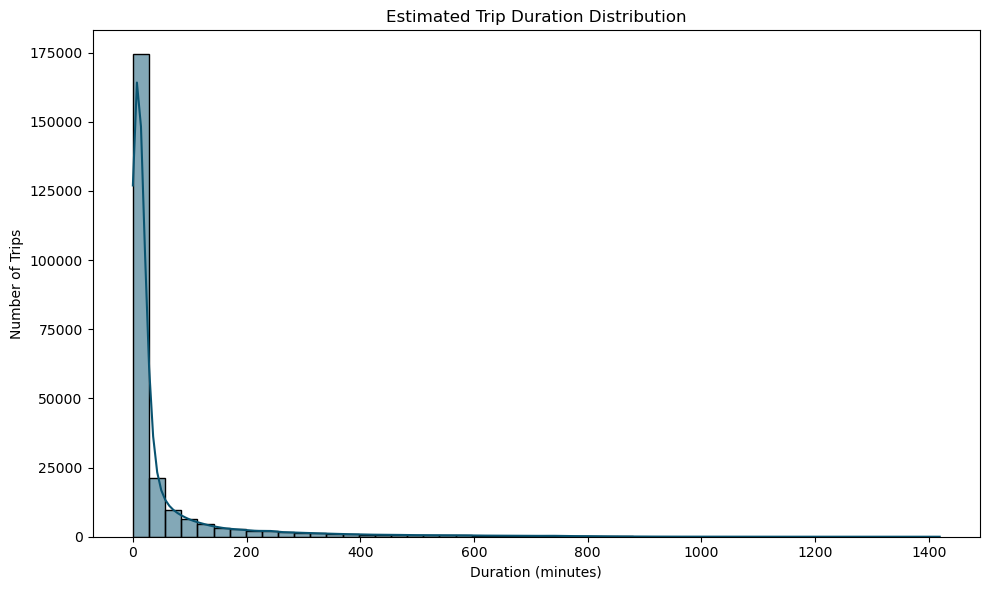

In [16]:
df['DATA_TIME'] = pd.to_datetime(df['DATA_TIME'], errors='coerce')

df_sorted = df.sort_values(['BIKE_ID', 'DATA_TIME'])

df_diff = (
    df_sorted
    .drop(columns='BIKE_ID') 
    .groupby(df_sorted['BIKE_ID'], group_keys=False)
    .apply(lambda x: x.loc[x['LOCK_STATUS'].diff().fillna(1) != 0])
    .reset_index(drop=True)
)

df_diff['BIKE_ID'] = df_sorted.loc[df_diff.index, 'BIKE_ID'].values

df_diff['DURATION'] = (
    df_diff
    .groupby('BIKE_ID')['DATA_TIME']
    .diff()
    .dt.total_seconds() / 60
)

df_diff = df_diff[df_diff['DURATION'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(df_diff['DURATION'].dropna(), bins=50, kde=True, color="#095370")
plt.title("Estimated Trip Duration Distribution")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

> The density plot shows bike trip durations, calculated as the time between consecutive unlock and lock events, with the dataset sorted by BIKE ID and DATE TIME to ensure accuracy and only positive durations retained. Most trips are short, peaking around 5–10 minutes, while a few extend up to 1400 minutes, possibly indicating docking errors. These patterns highlight the predominance of short trips and could inform pricing strategies, such as offering lower rates for brief rides.

### Bike Usage Frequency 

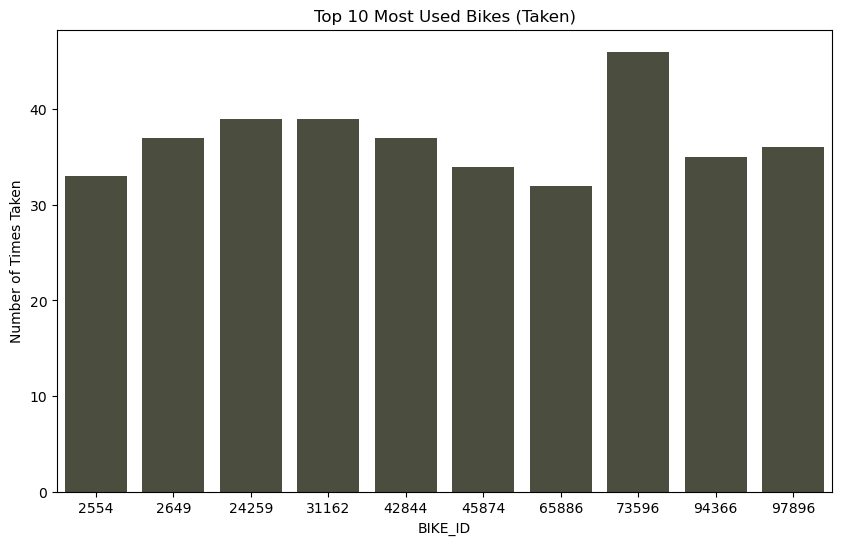

In [20]:
usage_counts = df[df['LOCK_STATUS'] == 1]['BIKE_ID'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=usage_counts.index, y=usage_counts.values, color="#4D4F3C")
plt.title("Top 10 Most Used Bikes (Taken)")
plt.xlabel("BIKE_ID")
plt.ylabel("Number of Times Taken")
plt.show()

> To identify the most frequently used bikes, usage frequency was analyzed by counting unlock events (LOCK STATUS = 1), and the top 10 bikes are shown in a barplot with frequency on the y-axis. Bike 73596 stood out for its high usage, likely due to its location in a high-traffic or easily accessible area. The visualization suggests that frequently used bikes are often well-maintained or optimally placed, while lower-usage bikes may require redistribution. High-demand bikes like 73596 may also need more frequent maintenance due to increased wear.

### Hourly Net Availability

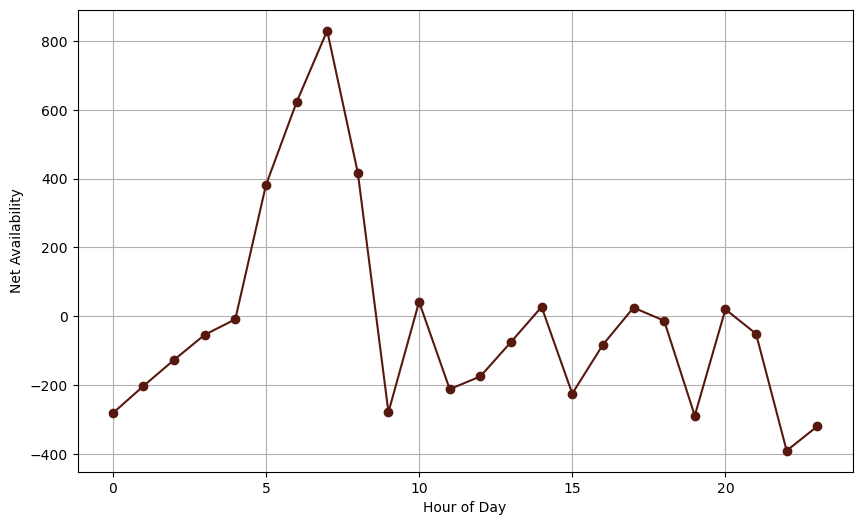

In [24]:
lock_counts = df_reset[df_reset['LOCK_STATUS'] == 1].groupby('Hour').size()
unlock_counts = df_reset[df_reset['LOCK_STATUS'] == 0].groupby('Hour').size()

net_availability = unlock_counts - lock_counts

plt.figure(figsize=(10, 6))
net_availability.plot(kind='line', marker='o', color="#57190F")
plt.xlabel("Hour of Day")
plt.ylabel("Net Availability")
plt.grid(True)
plt.show()

> Hourly net availability of bikes was calculated by comparing unlock and lock events each hour. A significant increase in unlocking activity occurs around 8 AM, peaking at +820, indicating a morning commuting rush. Around 9 AM, there's a sharp drop, suggesting bikes are returned shortly after the rush, likely at workplaces or schools. Between 3 PM and 9 PM, net availability remains near zero, reflecting a balance between pickups and returns during the evening commute. From 10 PM to 4 AM, net availability is negative or near zero, indicating minimal bike usage during late-night hours.

### Origin-Destination Graph

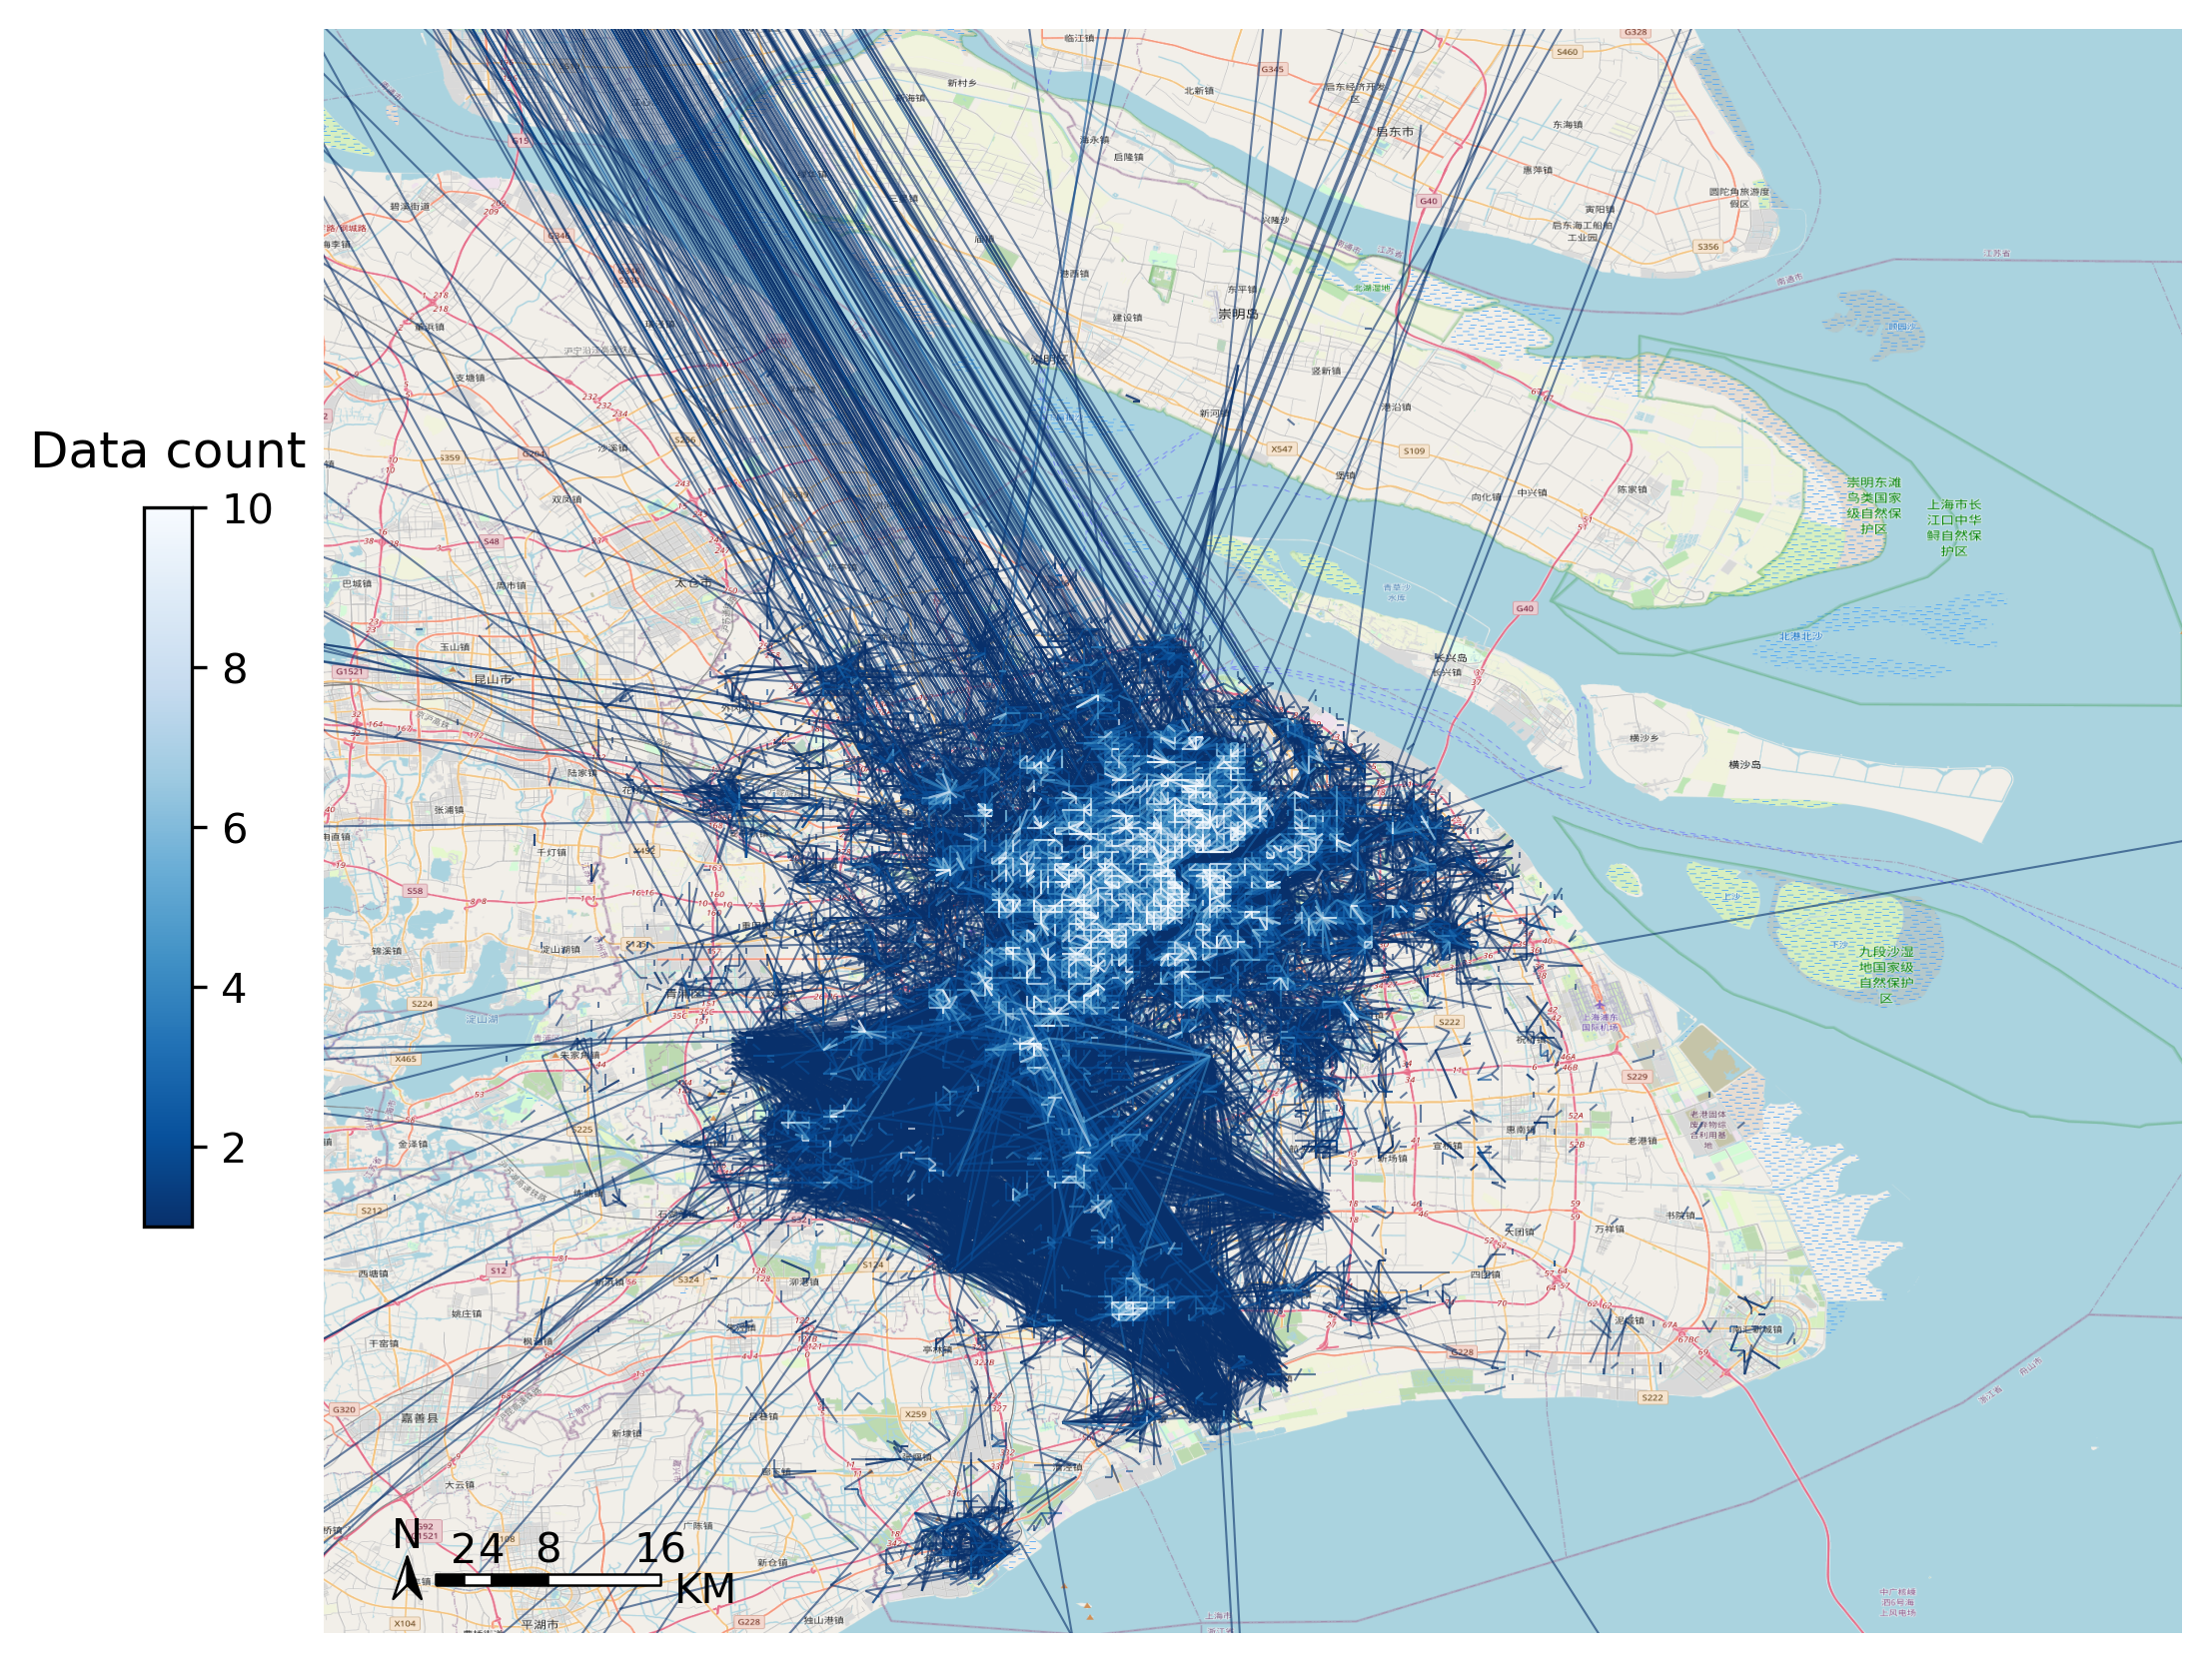

In [28]:
move_data, stop_data = tbd.bikedata_to_od(df,
                   col = ['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])

fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)

bounds = (120.85, 30.67, 122.24, 31.87)
params = tbd.area_to_params(bounds, accuracy=500)

od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

original_print = builtins.print
builtins.print = lambda *args, **kwargs: None  

tbd.plot_map(plt, bounds, zoom=11, style=8)

builtins.print = original_print  

cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count', pad=10)
plt.sca(ax)

od_gdf.plot(ax=ax, column='count', cmap='Blues_r', linewidth=0.5, alpha=0.6, vmax=10, cax=cax, legend=True)

tbd.plotscale(ax, bounds=bounds, textsize=10, compasssize=1, textcolor='black', accuracy=2000, rect=[0.06,0.03], zorder=10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

> The origin-destination (OD) graph created using the tbd.bikedata_to_od function, visualizes the flow of bike trips in a specific area of Shanghai, focusing on the central region bounded by coordinates 120.85, 30.67 and 122.24, 31.87, divided into a 500-meter grid for detailed analysis. The graph maps trips from origin (unlock) to destination (lock) points, with color indicating trip frequency—lighter blues representing high traffic and darker blues showing lower activity. This heatmap clearly highlights areas of concentrated bike usage, offering valuable insights for optimizing bike placement and rebalancing strategies across the city.